In [2]:
# lets do simulations / images with a crowded field, on the optimised pupil
# probably just calculate fisher info of everything
# / cramer rao bounds as a multiple of airy disk cramer raos

# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'magma'

from pathlib import Path

TypeError: yscale() missing 1 required positional argument: 'value'

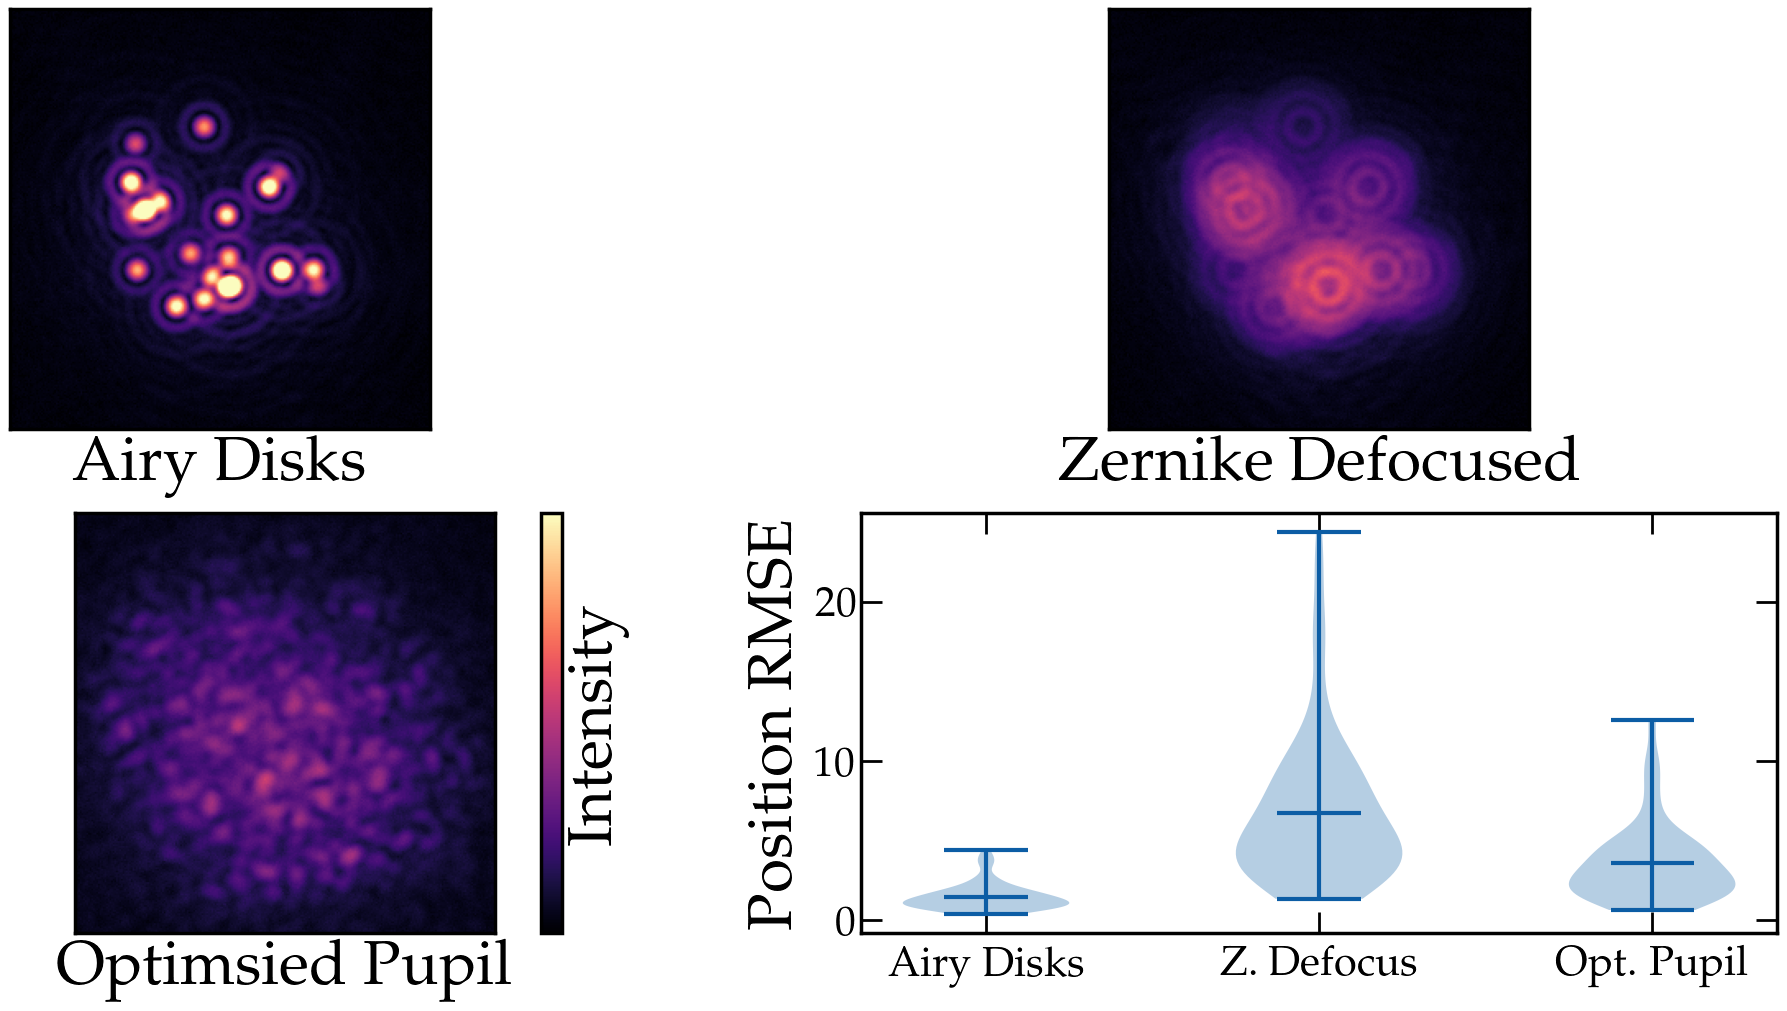

In [3]:
# jax random key
key = jr.PRNGKey(588)

wf_npix = 256 
diameter = 1 # 1 meter diameter

wavelength = 1e-6 # 1 micron wavelength

# This is to what degree we undersample Nyquist
nyquist_factor = 1
psf_npix = 64 / nyquist_factor
psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
oversample = nyquist_factor * 4 # sample at 4x nyquist originally

# number of sources, random positions
# let's go with the middle 75% of the psf
image_fac = 0.5
max_dist = dlu.arcsec2rad(psf_pixel_scale*psf_npix/2*image_fac)

n_sources = 20
positions = jr.uniform(key, (n_sources,2), minval = -max_dist, maxval = max_dist)

# uniform distribution of fluxes in logspace
log_fluxes = jr.uniform(key, (n_sources,) ,minval=5, maxval=6)
fluxes = 10**(log_fluxes)

# I wish I could just use the following, but it breaks with the fisher matrix (position inference)
# sources = dl.PointSources(np.array([wavelength]), positions, fluxes)
sources = []
for i in range(n_sources):
    source = dl.PointSource(np.array([wavelength]), positions[i], fluxes[i])
    sources.append(source)

scene = dl.Scene(sources)

# import the particular pupil
pupil = np.load("../../xk10/goodergrating.npy")

aperture_layer = dlT.TolimanApertureLayer(wf_npix)

pupil_layer = dl.AberratedLayer(phase = pupil)

layers = [
    (
        'aperture',
        aperture_layer
    ),
    (
        'pupil',
        pupil_layer
    )
]

optics = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample)

# optional detector
detector_layers = [
    (
        'downsample',
        dl.detector_layers.Downsample(1)
    )
]
detector = dl.LayeredDetector(detector_layers)

telescope = dl.Telescope(optics, scene, detector)

image = telescope.model()

# now for the airy disk:
layers_airy = [
    (
        'aperture',
        aperture_layer
    )
]

optics_airy = dl.AngularOpticalSystem(wf_npix, diameter, layers_airy, psf_npix, psf_pixel_scale, oversample)

telescope_airy = dl.Telescope(optics_airy, scene, detector)

image_airy = telescope_airy.model()

# zernike defocuser
diffuser = 1.7*dlu.zernike(4, dlu.pixel_coords(wf_npix*diameter, diameter), diameter)

diffuser_layer = dl.AberratedLayer(phase=diffuser)

layers_diffuser = [
    (
        'aperture',
        aperture_layer
    ),
    (
        'diffuser',
        diffuser_layer
    )
]

optics_diffuse = dl.AngularOpticalSystem(wf_npix, diameter, layers_diffuser, psf_npix, psf_pixel_scale, oversample)
telescope_diffuse = dl.Telescope(optics_diffuse, scene, detector)
image_diffuse = telescope_diffuse.model()

# toliman pupil
layers_tol = [
    (
        'aperture',
        aperture_layer
    ),
    (
        'pupil',
        dlT.TolimanPupilLayer(wf_npix)
    )
]

optics_tol = dl.AngularOpticalSystem(wf_npix, diameter, layers_tol, psf_npix, psf_pixel_scale, oversample)
telescope_tol = dl.Telescope(optics_tol, scene, detector)
image_tol = telescope_tol.model()

plt.style.use('../../wk17/sty.mplstyle')

defocpos = np.load('../../xk10/defocpos.npy')
pupilpos = np.load('../../xk10/pupilpos.npy')
airypos = np.load('../../xk10/airypos.npy')

# Flatten them
data = [airypos.ravel(), defocpos.ravel(), pupilpos.ravel()]

plt.figure(figsize=(26,12))
plt.subplot(2,2,1)
plt.imshow(np.minimum((jr.poisson(key, image_airy))**0.5,60))
plt.xticks([])
plt.yticks([])
plt.xlabel('Airy Disks')

plt.subplot(2,2,2)
plt.imshow(jr.poisson(key,image_diffuse)**0.5, vmax=60)
plt.xticks([])
plt.yticks([])
plt.xlabel('Zernike Defocused')

plt.subplot(2,2,3)
plt.imshow(jr.poisson(key,image)**0.5, vmax=60)
cbar = plt.colorbar()
cbar.set_ticks([])
cbar.set_label('Intensity')
plt.xticks([])
plt.yticks([])
plt.xlabel('Optimsied Pupil')

plt.subplot(2,2,4)
plt.violinplot(data, showmeans=True)
plt.xticks([1, 2, 3], ['Airy Disks', 'Z. Defocus', 'Opt. Pupil'])
plt.ylabel(r'Position RMSE')
plt.yscale()

plt.tight_layout()

#plt.savefig('disksandpupils.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
optics_airy_small = dl.AngularOpticalSystem(wf_npix, diameter, layers_airy, psf_npix*2, psf_pixel_scale, oversample)
optics_small = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npix*2, psf_pixel_scale, oversample)

optics_z_small = dl.AngularOpticalSystem(wf_npix, diameter, layers_diffuser, psf_npix*2, psf_pixel_scale, oversample)

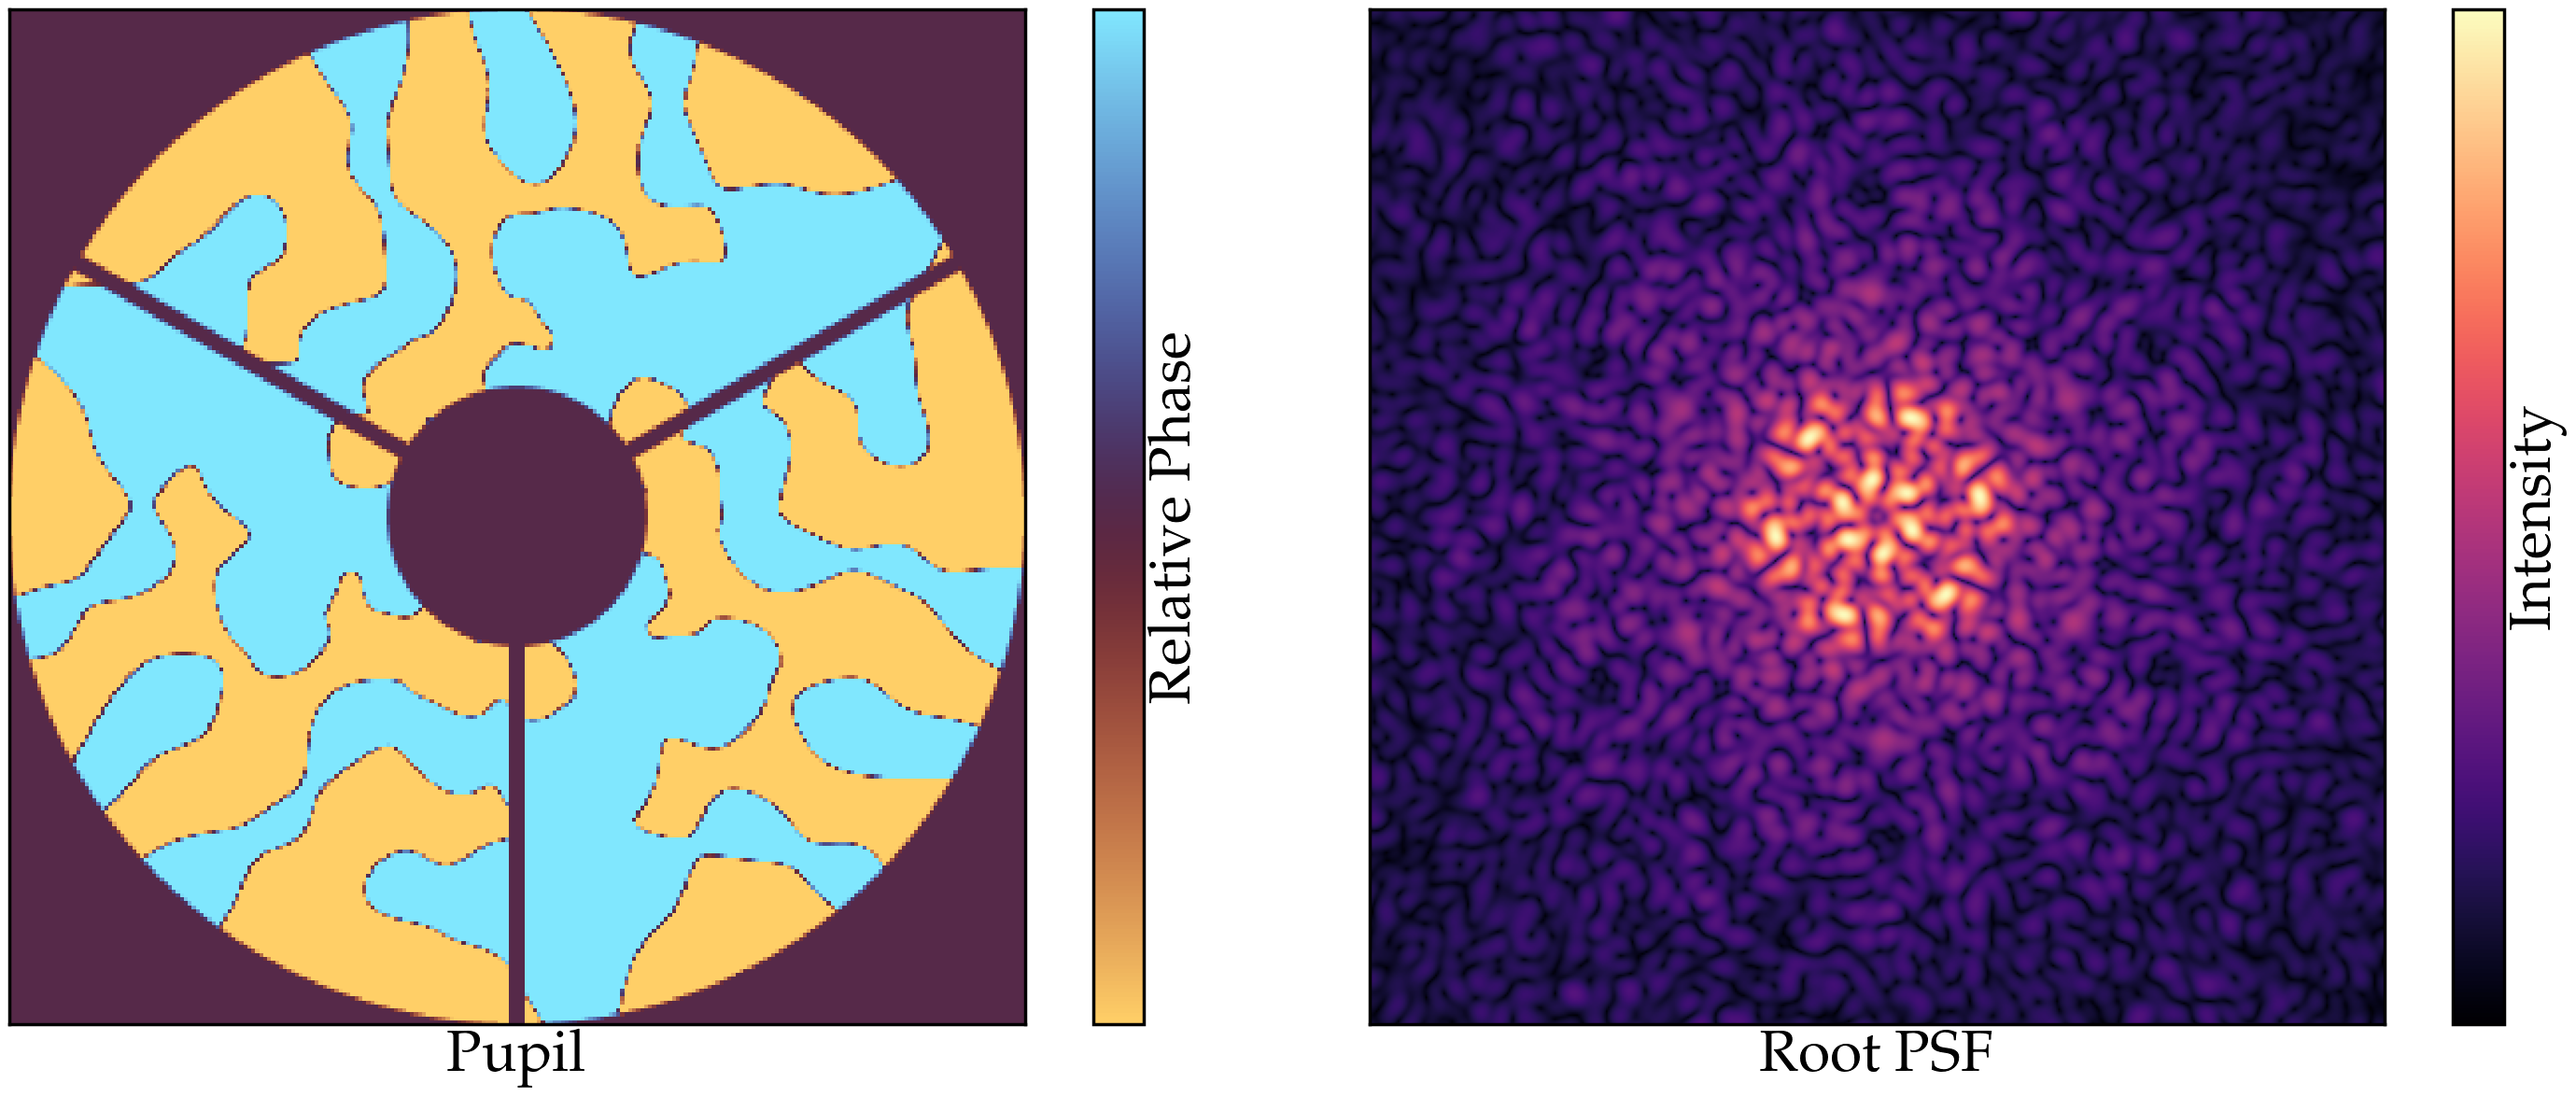

In [5]:
plt.style.use('../../wk17/sty.mplstyle')
plt.rcParams["image.cmap"] = 'magma'

import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

psf = optics_small.propagate(wavelength)**0.5

plt.figure(figsize=(30,12))
plt.subplot(1,2,1)
plt.imshow((pupil/np.max(pupil)*2 - 1)*optics.transmission, cmap='managua')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_ticks([])
cbar.set_label('Relative Phase')
plt.xlabel('Pupil')

plt.subplot(1,2,2)
plt.imshow(psf**0.5)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_ticks([])
cbar.set_label('Intensity')
plt.xlabel('Root PSF')

plt.tight_layout()

plt.savefig('abpupilpsf.pdf', dpi=300, bbox_inches='tight')
plt.show()

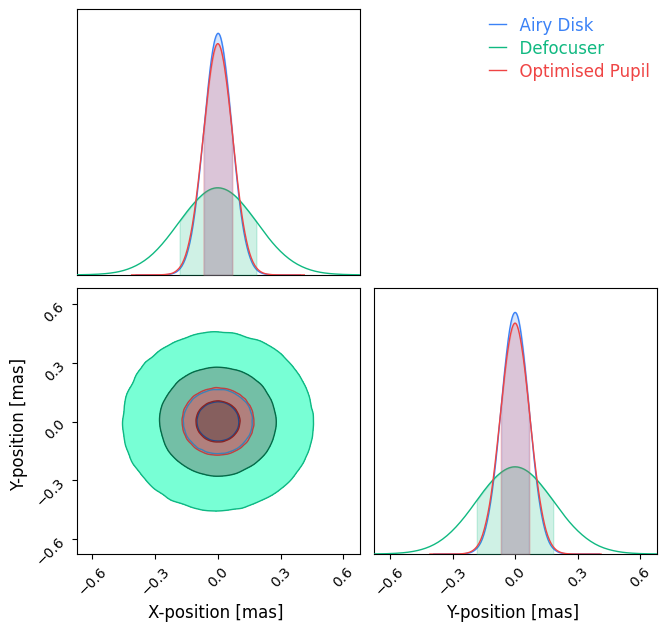

In [77]:
plt.style.use('default')
from chainconsumer import ChainConsumer, Chain
param_names = ["X-position [mas]","Y-position [mas]"]
X = np.zeros(len(param_names))

c = ChainConsumer()
# This 'commented out' one is just before optimisation
# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=dlu.rad2arcsec(covs[0]), columns=param_names, name="Initial")
# )

# To convert to arcsec, have to square the conversion factor
cov_to_arcsec = dlu.rad2arcsec(1000)**2

c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov_airy*cov_to_arcsec, columns=param_names, name="Airy Disk")
)

c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov_z*cov_to_arcsec, columns=param_names, name='Defocuser')
)

c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov_pupil*cov_to_arcsec, columns=param_names, name='Optimised Pupil')
)

fig = c.plotter.plot()
fig.savefig('figrte.pdf', bbox_inches='tight')

In [114]:
defocpos = np.load('../../xk10/defocpos.npy')
pupilpos = np.load('../../xk10/pupilpos.npy')
airypos = np.load('../../xk10/airypos.npy')

# Flatten them
data = [airypos.ravel(), defocpos.ravel(), pupilpos.ravel()]

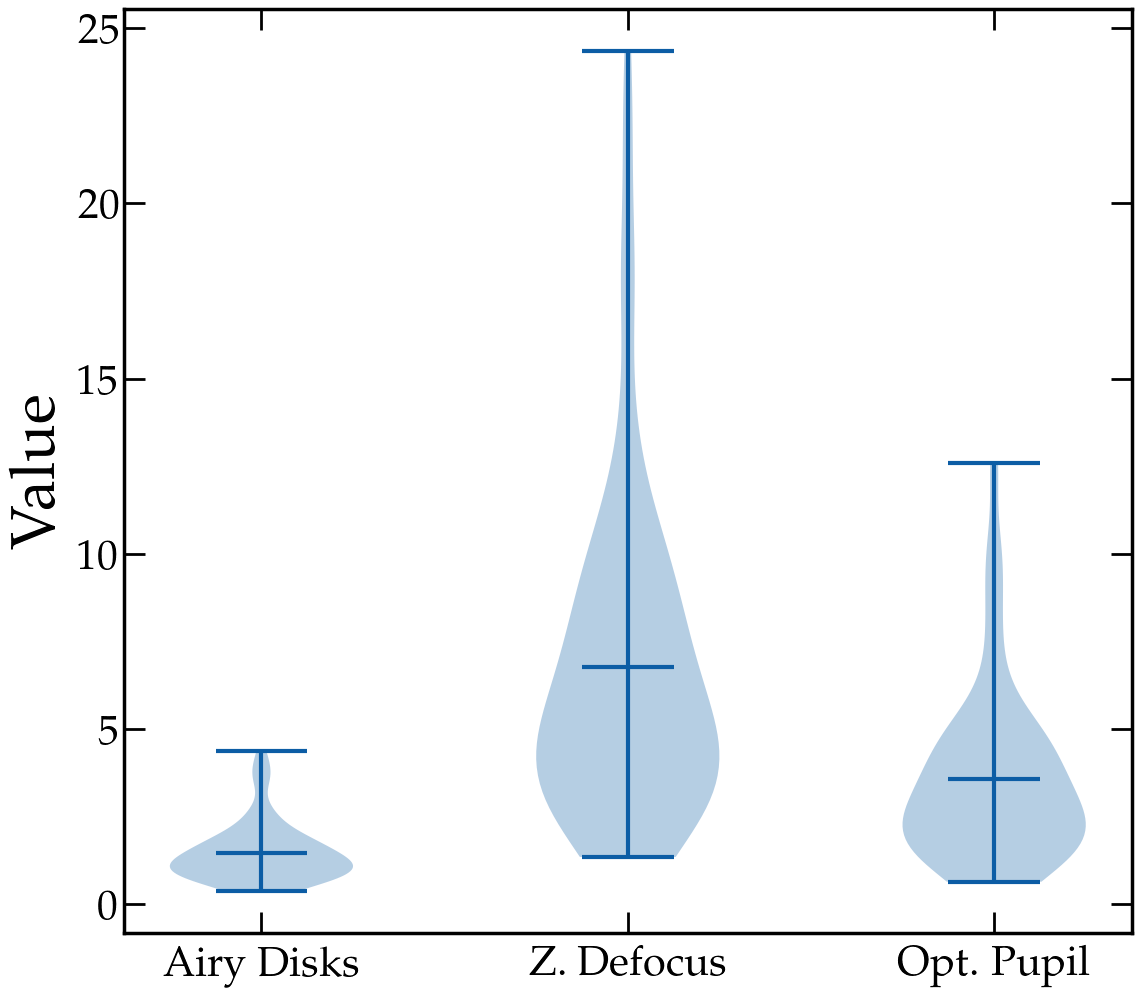

In [ ]:
plt.violinplot(data, showmeans=True)
plt.xticks([1, 2, 3], ['Airy Disks', 'Z. Defocus', 'Opt. Pupil'])
plt.ylabel(r'')
plt.show()


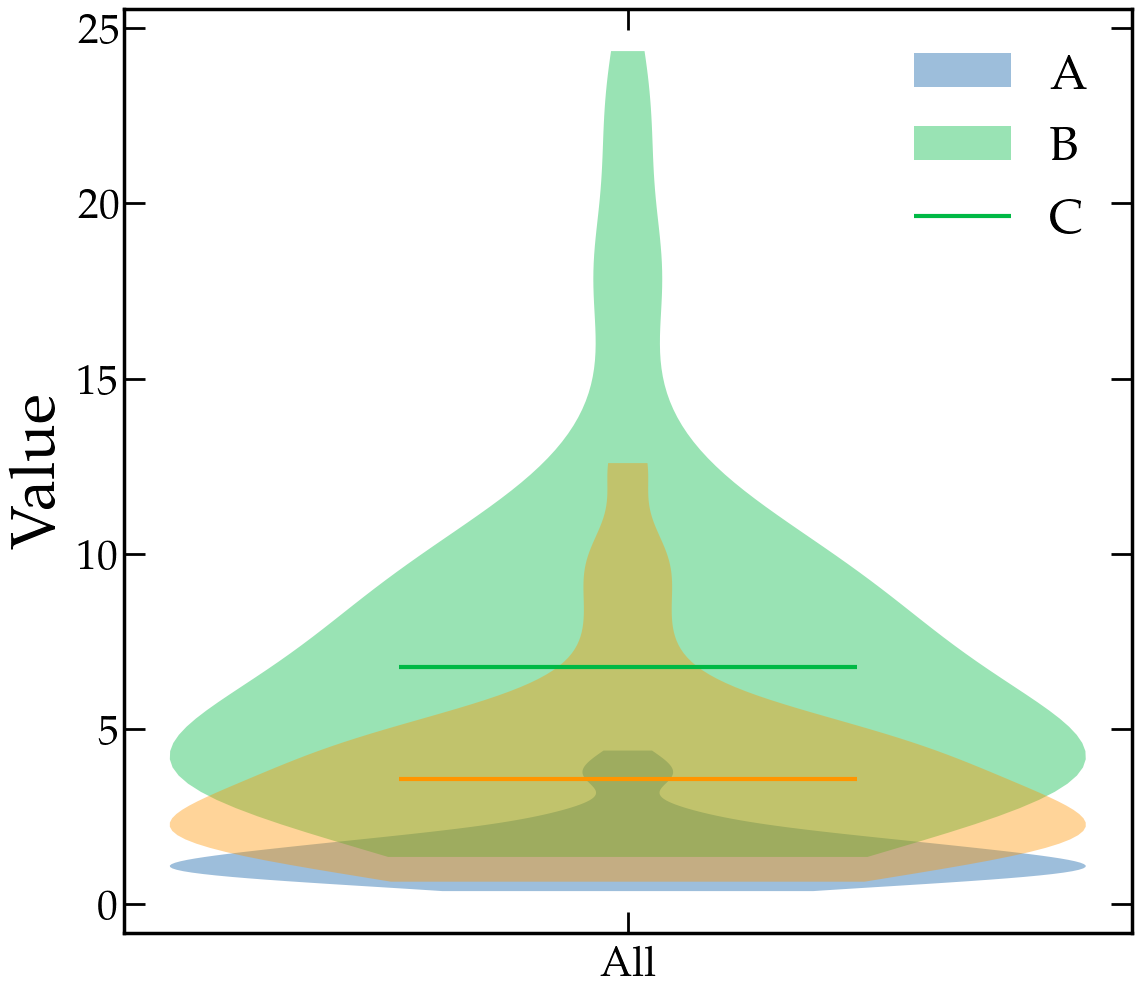

In [ ]:
# Make figure
fig, ax = plt.subplots()

# Common x-position (all overlap)
pos = [1]

# Plot each violin manually
parts_a = ax.violinplot(airypos.ravel(), positions=pos, widths=0.9, showmeans=False, showextrema=False, showmedians=False)
for pc in parts_a['bodies']:
    pc.set_facecolor('C0')
    pc.set_alpha(0.4)

parts_b = ax.violinplot(defocpos.ravel(), positions=pos, widths=0.9, showmeans=False, showextrema=False, showmedians=False)
for pc in parts_b['bodies']:
    pc.set_facecolor('C1')
    pc.set_alpha(0.4)

parts_c = ax.violinplot(pupilpos.ravel(), positions=pos, widths=0.9, showmeans=True, showextrema=False, showmedians=False)
for pc in parts_c['bodies']:
    pc.set_facecolor('C2')
    pc.set_alpha(0.4)

# Labels
ax.set_xticks(pos)
ax.set_xticklabels(['All'])
ax.set_ylabel('Value')
ax.legend(['A', 'B', 'C'])
plt.show()
